# Predicting Research Article Topics through NLP Analysis

## Problem statement

Researchers have access to large online archives of scientific articles. As a consequence, finding relevant articles has become more difficult. Tagging or topic modelling provides a way to give token of identification to research articles which facilitates recommendation and search process.

Given the abstract and title for a set of research articles, predict the topics for each article included in the test set. 

Note that a research article can possibly have more than 1 topic. The research article abstracts and titles are sourced from the following 6 topics: 

1. Computer Science

2. Physics

3. Mathematics

4. Statistics

5. Quantitative Biology

6. Quantitative Finance

## Import Libraries

In [2]:
pip install lightgbm

Note: you may need to restart the kernel to use updated packages.


In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')


# NLTK modules
import nltk
nltk.download('punkt') #The Punkt tokenizer is used for tokenization
nltk.download('stopwords') 
nltk.download('wordnet') #This is often used in lemmatization.
from nltk.stem import PorterStemmer, WordNetLemmatizer

import re  #regular expressions

from gensim.models import Word2Vec # Word2Vec module
from gensim.parsing.preprocessing import preprocess_string, strip_tags, strip_punctuation, remove_stopwords, strip_numeric, stem_text
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder, StandardScaler, RobustScaler
from sklearn.pipeline import Pipeline

from sklearn.svm import LinearSVC
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
from imblearn.over_sampling import RandomOverSampler

from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

import os
excel_files = ['NLP_sample_submission.csv', 'NLP_test.csv','NLP_train.csv']

for filename in excel_files:
    print(os.path.abspath(filename))
# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

C:\Users\ASUS\NLP_sample_submission.csv
C:\Users\ASUS\NLP_test.csv
C:\Users\ASUS\NLP_train.csv


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\ASUS\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ASUS\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\ASUS\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


## Loading Dataset

In [5]:
train_data = pd.read_csv('NLP_train.csv')
test_data = pd.read_csv('NLP_test.csv')
submission_data = pd.read_csv('NLP_sample_submission.csv')

In [6]:
print(train_data.isnull().sum())
print(train_data.columns)

ID                      0
TITLE                   0
ABSTRACT                0
Computer Science        0
Physics                 0
Mathematics             0
Statistics              0
Quantitative Biology    0
Quantitative Finance    0
dtype: int64
Index(['ID', 'TITLE', 'ABSTRACT', 'Computer Science', 'Physics', 'Mathematics',
       'Statistics', 'Quantitative Biology', 'Quantitative Finance'],
      dtype='object')


## Feature Engineering
### Convert one-hot encoded fields to categories

In [7]:
# Converting binary column to category
to_convert = ['Computer Science', 'Physics', 'Mathematics','Statistics', 'Quantitative Biology', 'Quantitative Finance']

# Make a copy of train data
topic_data = train_data.copy()

In [8]:
topic_data.head(5)

,ID,TITLE,ABSTRACT,Computer Science,Physics,Mathematics,Statistics,Quantitative Biology,Quantitative Finance
0,1,Reconstructing Subject-Specific Effect Maps,Predictive models allow subject-specific inf...,1,0,0,0,0,0
1,2,Rotation Invariance Neural Network,Rotation invariance and translation invarian...,1,0,0,0,0,0
2,3,Spherical polyharmonics and Poisson kernels fo...,We introduce and develop the notion of spher...,0,0,1,0,0,0
3,4,A finite element approximation for the stochas...,The stochastic Landau--Lifshitz--Gilbert (LL...,0,0,1,0,0,0
4,5,Comparative study of Discrete Wavelet Transfor...,Fourier-transform infra-red (FTIR) spectra o...,1,0,0,1,0,0


In [9]:
# Changing the binary fields to categorical fields
topic_data = topic_data[topic_data[to_convert]==1].stack().reset_index().drop(0,1)

topic_data['ID'] = topic_data['level_0'].apply(lambda x: x+1)
topic_data = topic_data.drop('level_0', axis=1)

# Merge the data based on ID
merge_data = train_data.merge(topic_data, how='left', on='ID' )
# Drop all the binary fields
merge_data = merge_data.drop(to_convert, axis=1)


In [10]:
merge_data.head(5)

,ID,TITLE,ABSTRACT,level_1
0,1,Reconstructing Subject-Specific Effect Maps,Predictive models allow subject-specific inf...,Computer Science
1,2,Rotation Invariance Neural Network,Rotation invariance and translation invarian...,Computer Science
2,3,Spherical polyharmonics and Poisson kernels fo...,We introduce and develop the notion of spher...,Mathematics
3,4,A finite element approximation for the stochas...,The stochastic Landau--Lifshitz--Gilbert (LL...,Mathematics
4,5,Comparative study of Discrete Wavelet Transfor...,Fourier-transform infra-red (FTIR) spectra o...,Computer Science


In [11]:
# Rename the column to Category
merge_data = merge_data.rename({'level_1':'CATEGORY'}, axis=1)
merge_data.head(5)

,ID,TITLE,ABSTRACT,CATEGORY
0,1,Reconstructing Subject-Specific Effect Maps,Predictive models allow subject-specific inf...,Computer Science
1,2,Rotation Invariance Neural Network,Rotation invariance and translation invarian...,Computer Science
2,3,Spherical polyharmonics and Poisson kernels fo...,We introduce and develop the notion of spher...,Mathematics
3,4,A finite element approximation for the stochas...,The stochastic Landau--Lifshitz--Gilbert (LL...,Mathematics
4,5,Comparative study of Discrete Wavelet Transfor...,Fourier-transform infra-red (FTIR) spectra o...,Computer Science


## Explore Data

In [12]:
articles = merge_data

# list unique classes
print(np.unique(articles.CATEGORY))

['Computer Science' 'Mathematics' 'Physics' 'Quantitative Biology'
 'Quantitative Finance' 'Statistics']


In [13]:
pip install seaborn

Note: you may need to restart the kernel to use updated packages.


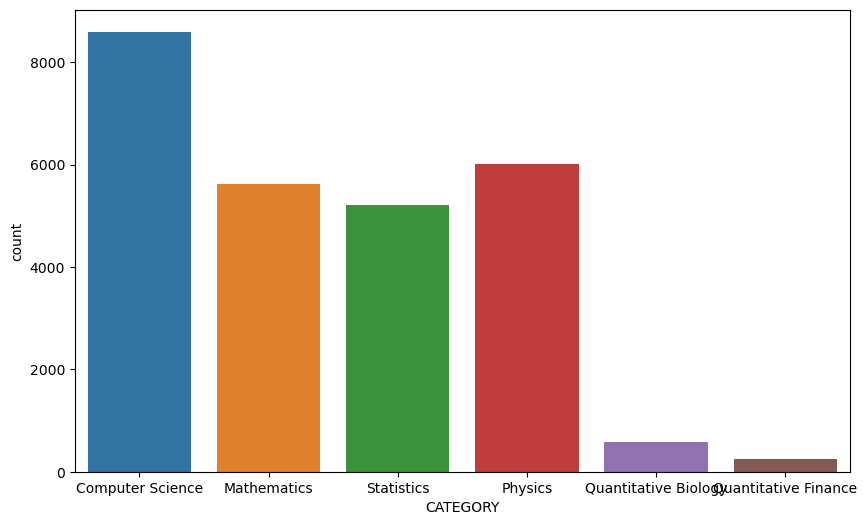

In [14]:
# Plot category data
plt.figure(figsize=(10,6))
sns.countplot(data=articles, x='CATEGORY')
plt.show()

## Data Preparation

In [15]:
# Stemmer object
porter = PorterStemmer()
wnl = WordNetLemmatizer()

class DataPreprocess:
    
    def __init__(self):
        self.filters = [strip_tags,
                       strip_numeric,
                       strip_punctuation,
                       lambda x: x.lower(),
                       lambda x: re.sub(r'\s+\w{1}\s+', '', x),
                       remove_stopwords]
    def __call__(self, doc):
        clean_words = self.__apply_filter(doc)
        return clean_words
    
    def __apply_filter(self, doc):
        try:
            cleanse_words = set(preprocess_string(doc, self.filters))
#             filtered_words = set(wnl.lemmatize(w) if w.endswith('e') or w.endswith('y') else porter.stem(w) for w in cleanse_words)
            return ' '.join(cleanse_words)
        except TypeError as te:
            raise(TypeError("Not a valid data {}".format(te)))

In [16]:
# Combine the Title and Abstract data
articles['TEXT'] = articles['TITLE'].map(str) + articles['ABSTRACT'].map(str)

articles['Processed'] = articles['TEXT'].apply(DataPreprocess())


In [17]:
articles['Processed'].shape

(26267,)

## Resampling Data

In [18]:
X = np.reshape(articles['Processed'].values, (-1,1))
y = np.reshape(articles['CATEGORY'].values, (-1,1))

ros = RandomOverSampler(sampling_strategy='minority', random_state=27)

X_res, y_res = ros.fit_resample(X, y)

print(X_res.shape, y_res.shape)

(34612, 1) (34612,)


## Feature Extraction

In [19]:
def vectorize(vector, X_train, X_test):
    vector_fit = vector.fit(X_train)
    
    X_train_vec = vector_fit.transform(X_train)
    X_test_vec = vector_fit.transform(X_test)
    
    print("Vectorization is completed.")
    return X_train_vec, X_test_vec

def label_encoding(y_train):
    """
        Encode the given list of class labels
        :y_train_enc: returns list of encoded classes
        :labels: actual class labels
    """
    lbl_enc = LabelEncoder()
    
    y_train_enc = lbl_enc.fit_transform(y_train)
    labels = lbl_enc.classes_
    
    return y_train_enc, labels


# Encode the class labels

In [20]:
X = X_res
y = y_res

y_enc_train, labels = label_encoding(y)

X_train, X_valid, y_train, y_valid = train_test_split(X, y_enc_train, test_size=0.3, shuffle=True)

In [21]:
print(X_train.shape, X_valid.shape)

(24228, 1) (10384, 1)


In [22]:
tfidf_vector = TfidfVectorizer(min_df=3, analyzer='word', 
                               strip_accents='unicode', 
                               token_pattern=r'\w{1}',
                               ngram_range=(1,3), 
                               max_features=3000,
                               use_idf=1, 
                               smooth_idf=1,
                                sublinear_tf=1,
                              stop_words='english')
# TFIDFVectorizer 
X_train_vec, X_valid_vec = vectorize(tfidf_vector, X_train.flatten(), X_valid.flatten())

Vectorization is completed.


## Build A Model

1. Light GBM - Score is 74.40
2. OneVsRestClassifier(SVC) - Score: 74.08
3. OneVsRestClassifier(LR) - Score: 75.39

In [23]:

# model = LinearSVC()
model = LogisticRegression(C=1.0, 
                           class_weight='balanced')

# Initialize OVR classifier with ML Algorithm
ovr = OneVsRestClassifier(estimator=model)

ovr.fit(X_train_vec, y_train)

OneVsRestClassifier(estimator=LogisticRegression(class_weight='balanced'))

In [24]:
# y_pred = lgbm_clf.predict(X_valid_vec)
y_pred = ovr.predict(X_valid_vec)

print("Accuracy: %1.3f \tPrecision: %1.3f \tRecall: %1.3f \tF1-Score: %1.3f\n" % (accuracy_score(y_valid, y_pred),
                                                                                     precision_score(y_valid, y_pred, average='micro'),
                                                                                     recall_score(y_valid, y_pred, average='micro'),
                                                                                     f1_score(y_valid, y_pred, average='micro')))

Accuracy: 0.734 	Precision: 0.734 	Recall: 0.734 	F1-Score: 0.734



## Prepare Test Data

In [25]:
test_data['Text'] = test_data['TITLE'] + test_data['ABSTRACT']

test_data['Processed'] = test_data['Text'].apply(DataPreprocess())

In [26]:
# Feature extraction
X_train_vec, X_test_vec = vectorize(tfidf_vector, X_train.flatten(), test_data['Processed'])

Vectorization is completed.


In [27]:
# y_preds = lgbm_clf.predict(X_test_vec)
y_preds = ovr.predict(X_test_vec)
test_df = test_data.copy()

test_df['category'] = pd.Series(y_preds, index=test_data.index)

In [28]:
test_df['category'].unique()

array([4, 2, 0, 5, 3, 1])

In [29]:

test_df[labels] = pd.get_dummies(test_df['category'], columns=labels)

final_df = test_df.drop(['TITLE', 'ABSTRACT', 'Text', 'Processed', 'category'], axis=1)

submission_data = final_df[submission_data.columns]

submission_data

submission_data.to_csv('multiclass_lr_04.csv', index=False)

In [31]:
submission_data.head(5)

,ID,Computer Science,Physics,Mathematics,Statistics,Quantitative Biology,Quantitative Finance
0,20973,0,0,0,0,0,1
1,20974,0,1,0,0,0,0
2,20975,0,1,0,0,0,0
3,20976,0,1,0,0,0,0
4,20977,1,0,0,0,0,0
